# Load the Packages

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import missingno
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import plotly.express as px
from collections import Counter
from nltk.tokenize import word_tokenize

# Load Data

In [2]:
# load the data

DATA_PATH = r"D:\reddit-sentiment-analysis\data\reddit.csv"

df = pd.read_csv(DATA_PATH)

df

clean_comment  category
0       family mormon have never tried explain them t...         1
1      buddhism has very much lot compatible with chr...         1
2      seriously don say thing first all they won get...        -1
3      what you have learned yours and only yours wha...         0
4      for your own benefit you may want read living ...         1
...                                                  ...       ...
37244                                              jesus         0
37245  kya bhai pure saal chutiya banaya modi aur jab...         1
37246              downvote karna tha par upvote hogaya          0
37247                                         haha nice          1
37248             facebook itself now working bjp’ cell          0

[37249 rows x 2 columns]

In [3]:
# rename columns

df.rename({"clean_comment":"comment",
           "category":"sentiment"},axis=1,inplace=True)

In [4]:
# missing data

df.isna().sum()

comment      100
sentiment      0
dtype: int64

**There are 100 missing values in the comment**

<Axes: >

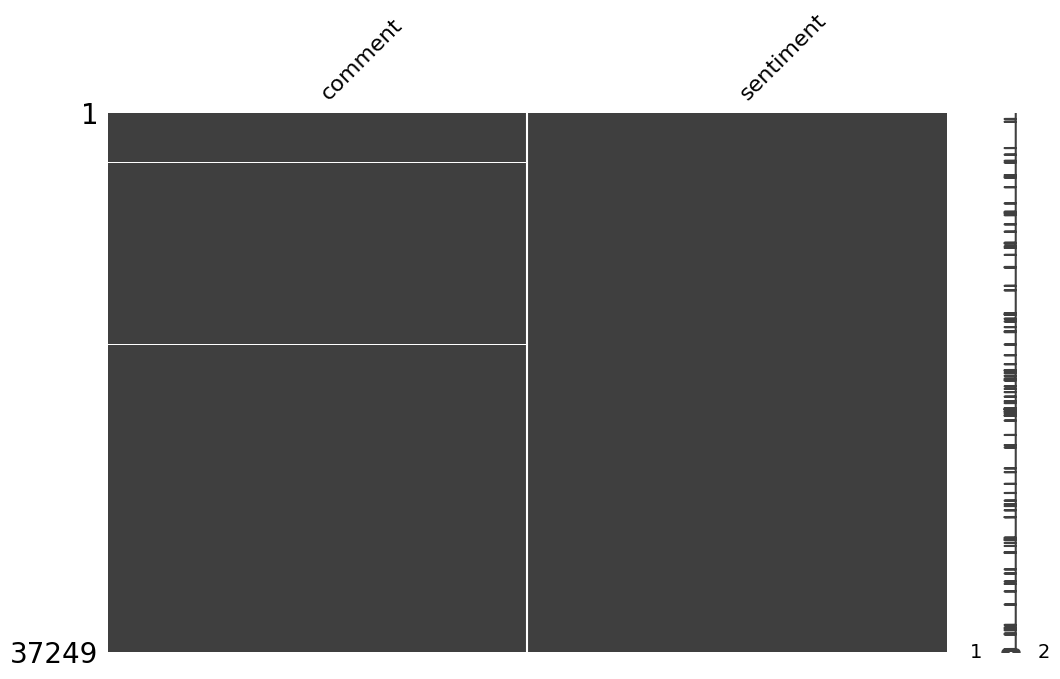

In [5]:
# missing values matrix

missingno.matrix(df,figsize=(12,7))

In [6]:
# rows that have missing values

(
    df.loc[
        df['comment'].isna()
    ]
)

comment  sentiment
413       NaN          0
605       NaN          0
2422      NaN          0
2877      NaN          0
3307      NaN          0
...       ...        ...
35975     NaN          0
36036     NaN          0
37043     NaN          0
37111     NaN          0
37238     NaN          0

[100 rows x 2 columns]

In [7]:
# sentiment of rows that have missing values

(
    df.loc[
        df['comment'].isna(),"sentiment"
    ]
    .value_counts()
)

sentiment
0    100
Name: count, dtype: int64

**All rows that have missing values have been labelled the sentiment of 0 (neutral)**

In [8]:
# check for duplicate comments in the data

print(df['comment'].dropna().duplicated().sum())

350


**`350` comments in the data are duplicated**

In [9]:
# shape of the data

data_rows, data_cols = df.shape
print(f'The data has {data_rows} rows and {data_cols} columns')

The data has 37249 rows and 2 columns


In [10]:
# comments having words like modi,bjp and congress

(
    df
    .dropna()
    .loc[(lambda df_: df_['comment'].str.contains(r"bjp|congress|modi")),"comment"]
)

51        tea partier expresses support for namo after ...
68           can congress eliminate namo and blame advani 
69        don know but surely there his statue every bj...
70       after seeing this uvjx3kwoehw video seems anyt...
72       congress needs bogeyman modi without the bad g...
                               ...                        
37210                                      modi april fool
37228    also modiji will give award ravish kumar tonight 
37236     fan modi but some the best people ever met li...
37245    kya bhai pure saal chutiya banaya modi aur jab...
37248               facebook itself now working bjp’ cell 
Name: comment, Length: 7055, dtype: object

In [11]:
# distribution of such comments

print(
      df['comment']
      .dropna()
      .str.contains(r"bjp|congress|modi")
      .mean() * 100
    )

18.991089935126112


# Data Cleaning

In [12]:
len(df.loc[14037,'comment'].split())

2

In [13]:
def remove_whitespaces(ser):
    return ser.str.lstrip().str.rstrip()

def count_words(text):
    return len(text.split(" "))

def removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    return text

def removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def clean_text(text):
    text = removing_numbers(text)
    text = removing_punctuations(text)
    text = removing_urls(text)
    return text

def sentence_length(ser):
    bins = [0,10, 25, 50, ser.max()]
    labels = ['Short', 'Medium', 'Long', 'Very Long']
    return pd.cut(ser,bins=bins,labels=labels)

def is_response(ser):
    return np.where(ser <= 3, 1, 0)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_sentence)

def lemmatize(text):
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(word) for word in text.split(" ")]
    return " ".join(text)


In [14]:
def remove_emoji(text):
    # Regex pattern to match all emoji characters
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
        u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and pictographs extended-A
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_non_ascii(text):
    # Remove all non-ASCII characters
    return re.sub(r'[^\x00-\x7F]+', '', text)

def remove_chinese(text):
    # Regex to remove Chinese characters (CJK Unified Ideographs)
    return re.sub(r'[\u4e00-\u9fff]+', '', text)

def clean_unicode_text(text):
    # Apply all cleaning functions
    text = remove_emoji(text)
    text = remove_chinese(text)
    text = remove_non_ascii(text)
    return text

In [15]:
df['comment'].dropna().apply(count_words)

0         41
1        197
2         87
3         30
4        113
        ... 
37244      1
37245     19
37246      8
37247      3
37248      7
Name: comment, Length: 37149, dtype: int64

In [16]:
def count_pos_tags(text):
    tokens = nltk.word_tokenize(text)  
    pos_tags = nltk.pos_tag(tokens)    
    
    # Define POS categories
    nouns = ['NN', 'NNS', 'NNP', 'NNPS']
    verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    adjectives = ['JJ', 'JJR', 'JJS']
    
    # Count the POS tags
    pos_counts = Counter(tag for word, tag in pos_tags)

    num_nouns = sum(pos_counts[pos] for pos in nouns)
    num_verbs = sum(pos_counts[pos] for pos in verbs)
    num_adjectives = sum(pos_counts[pos] for pos in adjectives)
    return pd.Series({'nouns': num_nouns, 'verbs': num_verbs, 'adjectives': num_adjectives})

In [17]:
def clean_data(data):

    return (
        data
        .dropna()
        .drop_duplicates(subset=['comment'])
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(clean_text)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].str.lstrip().str.rstrip().str.lower(),
            word_count = lambda df_: df_.loc[:,"comment"].apply(count_words),
            named_sentiment = lambda df_: df_.loc[:,"sentiment"].replace({0:"neutral",
                                                                         -1:"negative",
                                                                          1:"positive"}),
            sentence_length = lambda df_: df_.loc[:,"word_count"].pipe(sentence_length),
            response = lambda df_: df_.loc[:,"word_count"].pipe(is_response)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(removing_punctuations)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(clean_unicode_text)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(remove_stopwords)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(lemmatize)
        )
        .loc[lambda df_: ~(df_['comment'].str.contains(r"bjp|congress|modi")),:]
    )

In [18]:
final_df = clean_data(df)

In [19]:
final_df.sample(30)

comment  sentiment  \
579    monitor mount stand asus overlord would love m...          1   
1492      lol ironic still bad fat spammer ugandan woman          1   
28824  casualty balakot pakistan responded aggressive...          0   
4484   bad idea scheme transfer public money realtor ...         -1   
2642   whether opportunist public relation genuine ca...          1   
12757   think yogi adityanath would bigger problem think          0   
5265   toi link posted lol fierce love hate relations...          1   
565       song might enjoy name awesome build edqhofrqrm          1   
16392                      aww yeah thanks thread rootsy          1   
20690  firmly believe political party reflection soci...         -1   
16184  rahul gandhi another case thug life give shit ...         -1   
27833  dude fine dandy offered support sympathy time ...          1   
26749  want like rimworld stupid refund cause tried p...         -1   
25696                         lol sadyogi face thumbnail          1   
13070  alright whenever people look belgium art work ...          0   
4583          canada approve arrival visa indian tourist          0   
23630  better list top instead big text dbt poorest p...          1   
7785   well least randians aware ujala scheme scheme ...          1   
115                                         put day back          0   
26968                  wonder tulsi gabbard think strike          0   
31595                                 pak took seriously         -1   
34212  arun jaitley biggest silent mother fcuker get ...          1   
9908   play gronk sorta thinking since eifort could f...          0   
8217                           mudiji appreciating asset          0   
24030  infrastructure road public housing sleep giant...          1   
19176  ravish amazing also downplay ndtv role sure go...          1   
30192  anyone basic sense hygeine would live practica...          1   
1348   feel today ever going find aircraft ship come ...          0   
13483                                    look evil smile         -1   
36290  hope common sense prevails rule anyone see eff...         -1   

       word_count named_sentiment sentence_length  response  
579            23        positive          Medium         0  
1492           15        positive          Medium         0  
28824          22         neutral          Medium         0  
4484            8        negative           Short         0  
2642           26        positive            Long         0  
12757          11         neutral          Medium         0  
5265           13        positive          Medium         0  
565            10        positive           Short         0  
16392           7        positive           Short         0  
20690          91        negative       Very Long         0  
16184          17        negative          Medium         0  
27833          44        positive            Long         0  
26749          24        negative          Medium         0  
25696           6        positive           Short         0  
13070          36         neutral            Long         0  
4583            9         neutral           Short         0  
23630          58        positive       Very Long         0  
7785           20        positive          Medium         0  
115             4         neutral           Short         0  
26968           8         neutral           Short         0  
31595           4        negative           Short         0  
34212          18        positive          Medium         0  
9908           20         neutral          Medium         0  
8217            5         neutral           Short         0  
24030          12        positive          Medium         0  
19176          43        positive            Long         0  
30192          11        positive          Medium         0  
1348           12         neutral          Medium         0  
13483           5        negative           Short

In [20]:
# form the pos tag count data

pos_tag_data = final_df['comment'].apply(count_pos_tags)

In [21]:
pos_tag_data

nouns  verbs  adjectives
0         16      4           2
1         58     30          24
2         18      7          10
3          7      4           2
4         20     19          12
...      ...    ...         ...
37242      8      0           0
37243      7      5           2
37244      1      0           0
37246      4      0           1
37247      2      0           0

[29753 rows x 3 columns]

In [22]:
final_df = final_df.join(pos_tag_data)

In [23]:
# check cleaned df for missing values

final_df.isna().sum()

comment            0
sentiment          0
word_count         0
named_sentiment    0
sentence_length    0
response           0
nouns              0
verbs              0
adjectives         0
dtype: int64

In [24]:
# shape of cleaned data

final_df.shape

(29753, 9)

# EDA

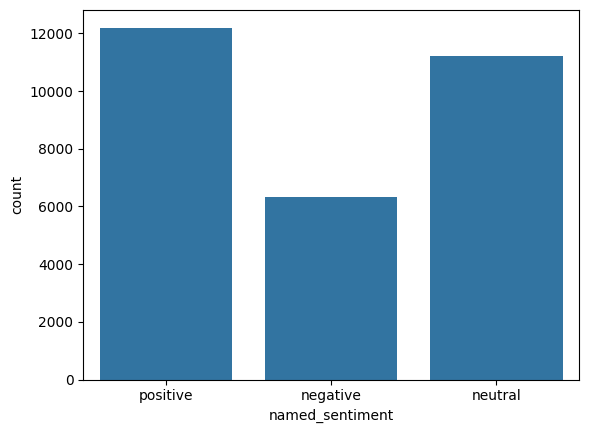

In [25]:
# distribution of classes

sns.countplot(data=final_df,x="named_sentiment");

**Clearly the data shows class imbalance**

In [26]:
# frequency distribution of sentiments

final_df['named_sentiment'].value_counts(normalize=True).mul(100).round(2)

named_sentiment
positive    41.01
neutral     37.68
negative    21.31
Name: proportion, dtype: float64

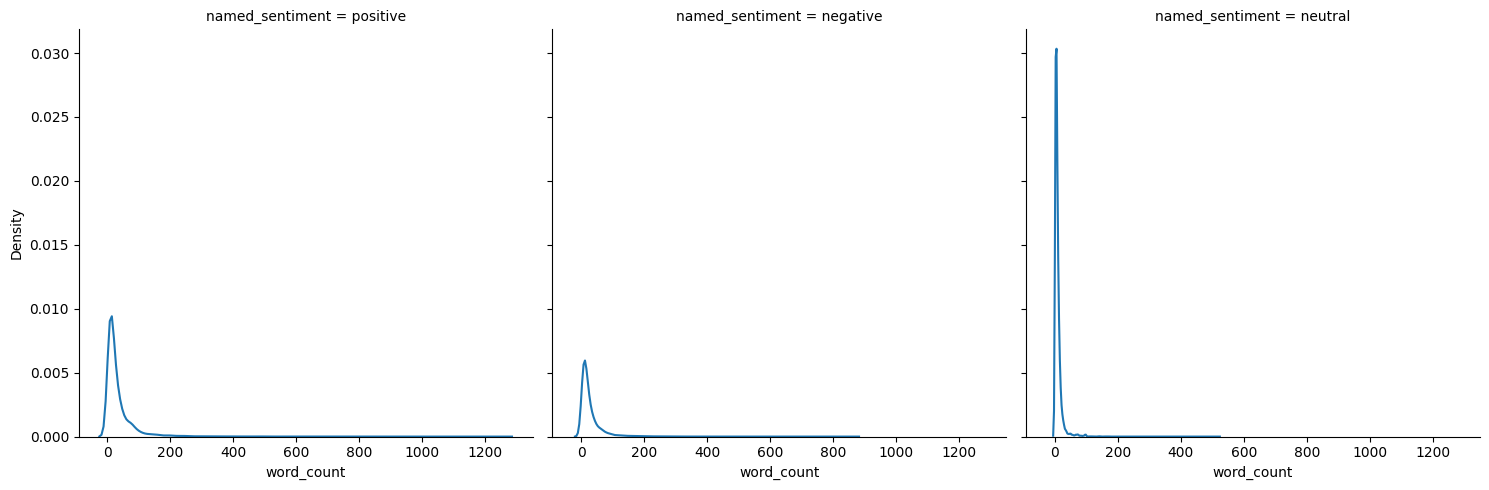

In [27]:
# distribution of word_count per sentiment

sns.displot(final_df,x='word_count',col='named_sentiment',kind='kde');

In [28]:
# statistical summary of word_count

sentiment_grp = final_df.groupby("named_sentiment")

sentiment_grp['word_count'].agg(["min","max","median","mean"])

min   max  median       mean
named_sentiment                              
negative           1   862    17.0  28.119577
neutral            1   518     6.0   9.370942
positive           1  1258    18.0  34.547369

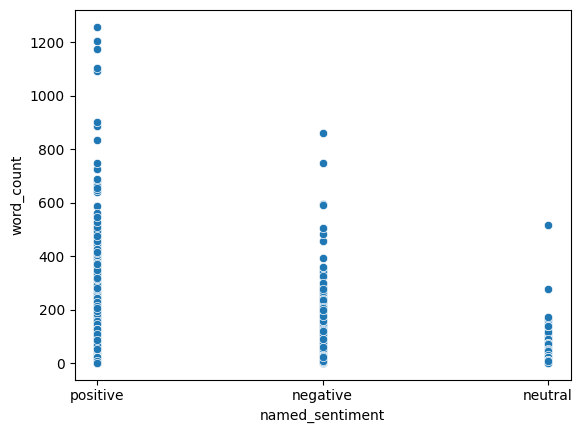

In [29]:
#sentiment vs word_count

sns.scatterplot(final_df,x='named_sentiment',y='word_count');

In [30]:
# sentiment vs word count --> boxplots

px.box(data_frame=final_df,x='named_sentiment',y='word_count')

In [31]:
# distribution of sentence length based on sentiment

pd.crosstab(index=final_df['named_sentiment'],columns=final_df['sentence_length'],normalize=True).mul(100)

sentence_length      Short     Medium      Long  Very Long
named_sentiment                                           
negative          6.439687   7.834504  4.144120   2.887104
neutral          27.724935   8.116829  1.230128   0.611703
positive         12.479414  13.249084  7.911807   7.370685

In [32]:
import warnings

warnings.filterwarnings("ignore")
fig = px.sunburst(final_df,path=['named_sentiment','sentence_length'],width=700,height=700)
fig.show()

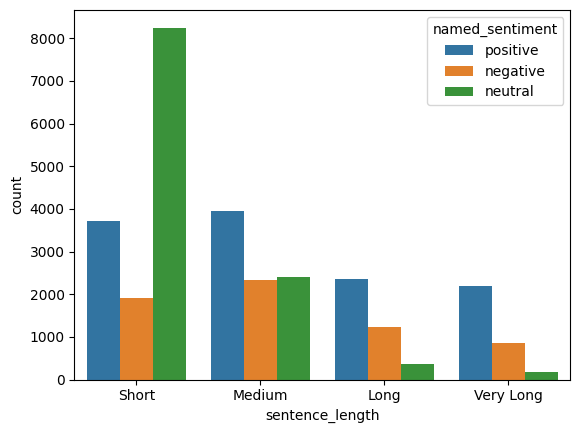

In [33]:
# sentence length distribution among sentences

sns.countplot(final_df,x='sentence_length',hue='named_sentiment');

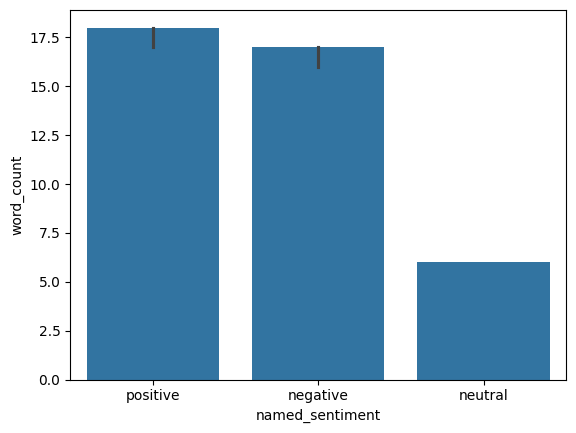

In [34]:
# median word counts among sentiments

sns.barplot(final_df,x='named_sentiment',y='word_count',estimator='median');

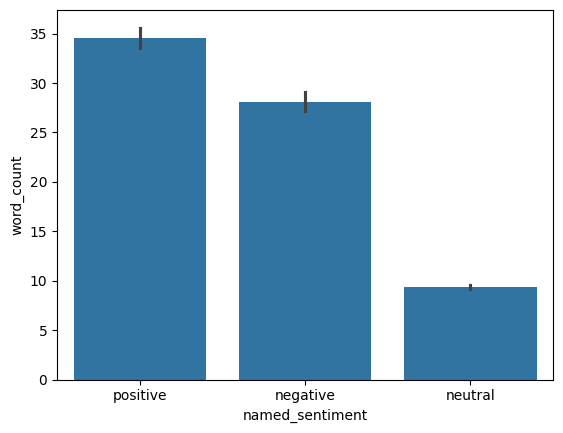

In [35]:
# avg word counts among sentiments

sns.barplot(final_df,x='named_sentiment',y='word_count',estimator='mean');

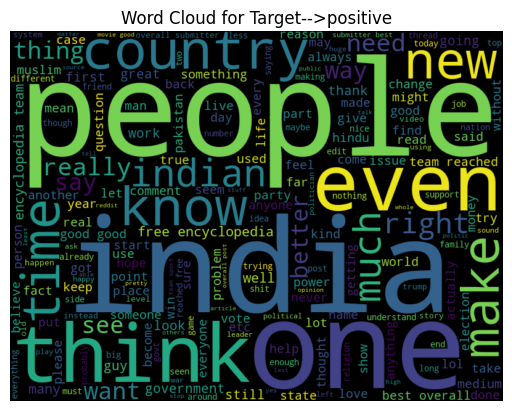

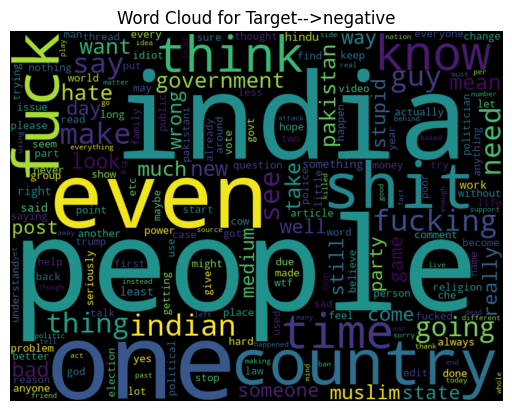

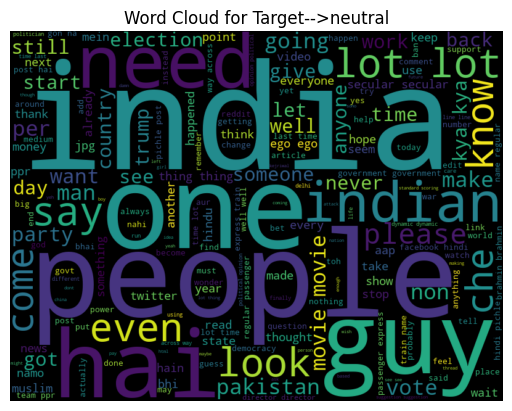

In [36]:
# plot wordclouds for each sentiment

def plot_wordcloud(target_class):
    text = ' '.join(final_df.loc[(final_df['named_sentiment'] == target_class),"comment"])
    wordcloud = WordCloud(width=800, height=600).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Target-->{target_class}')
    plt.show()

for sentiment in final_df['named_sentiment'].unique().tolist():
    plot_wordcloud(sentiment)

In [37]:
# top 15 words and their count in each sentiment

def tokenize_sentences(text):
    tokens = nltk.word_tokenize(text)
    return tokens

tokens = final_df.loc[:,"comment"].apply(tokenize_sentences)

positive_tokens = tokens.loc[final_df['named_sentiment'] == "positive"].sum()
neutral_tokens = tokens.loc[final_df['named_sentiment'] == "neutral"].sum()
negative_tokens = tokens.loc[final_df['named_sentiment'] == "negative"].sum()

In [38]:
# find the top 15 words

def get_top_words(tokens, n=10):
    word_counts = Counter(tokens)
    return word_counts.most_common(n)

top_15_positive = get_top_words(positive_tokens,15)
top_15_neutral = get_top_words(neutral_tokens,15)
top_15_negative = get_top_words(negative_tokens,15)

print("Top 10 words for Positive sentiment:", top_15_positive)
print("Top 10 words for Neutral sentiment:", top_15_neutral)
print("Top 10 words for Negative sentiment:", top_15_negative)

Top 10 words for Positive sentiment: [('good', 2358), ('people', 2222), ('like', 2080), ('india', 1894), ('one', 1665), ('would', 1399), ('get', 1336), ('time', 1173), ('even', 1123), ('think', 1073), ('right', 1056), ('thing', 1003), ('make', 985), ('indian', 985), ('know', 943)]
Top 10 words for Neutral sentiment: [('like', 540), ('india', 497), ('hai', 458), ('lot', 434), ('one', 391), ('time', 351), ('people', 313), ('get', 284), ('think', 261), ('thing', 245), ('che', 222), ('guy', 219), ('indian', 216), ('post', 208), ('kya', 205)]
Top 10 words for Negative sentiment: [('people', 1010), ('like', 894), ('india', 838), ('one', 719), ('get', 567), ('indian', 510), ('shit', 501), ('fuck', 493), ('thing', 488), ('even', 482), ('time', 482), ('would', 449), ('country', 421), ('know', 406), ('think', 399)]


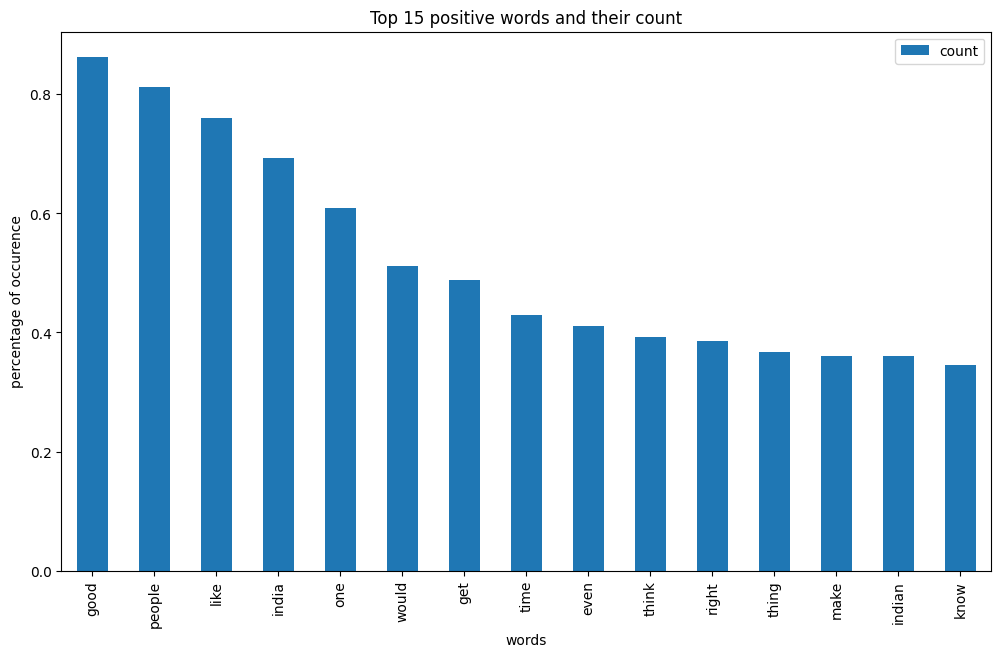

In [39]:
# bar plot for top 15 positive sentiment words
(
    pd.DataFrame(top_15_positive,columns=['word','count'])
    .set_index('word')
    .div(len(positive_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 positive words and their count")
plt.show()

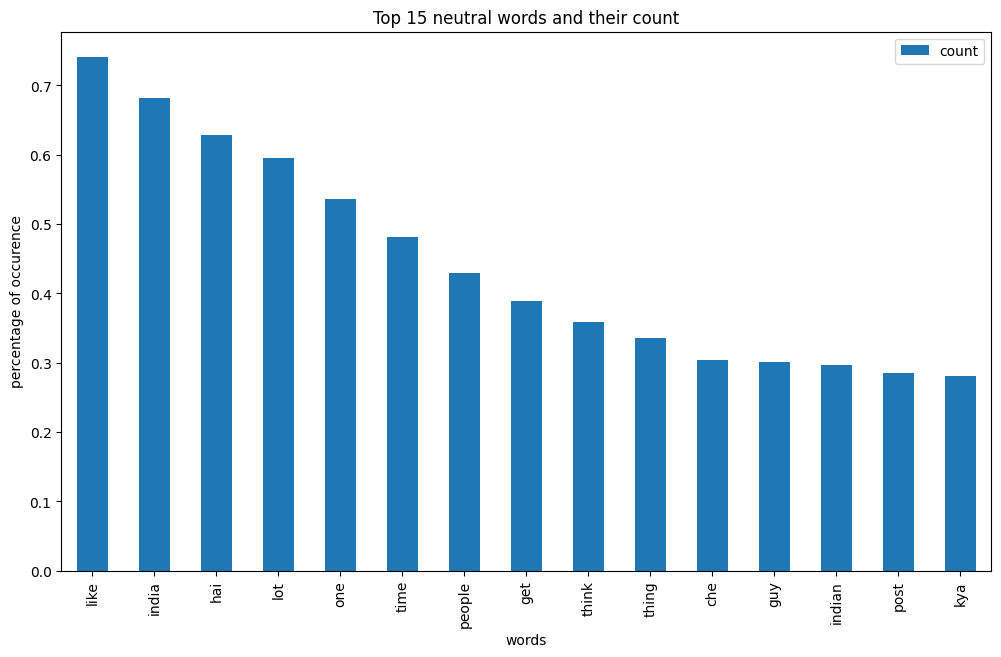

In [40]:
# bar plot for top 15 neutral sentiment words
(
    pd.DataFrame(top_15_neutral,columns=['word','count'])
    .set_index('word')
    .div(len(neutral_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 neutral words and their count")
plt.show()

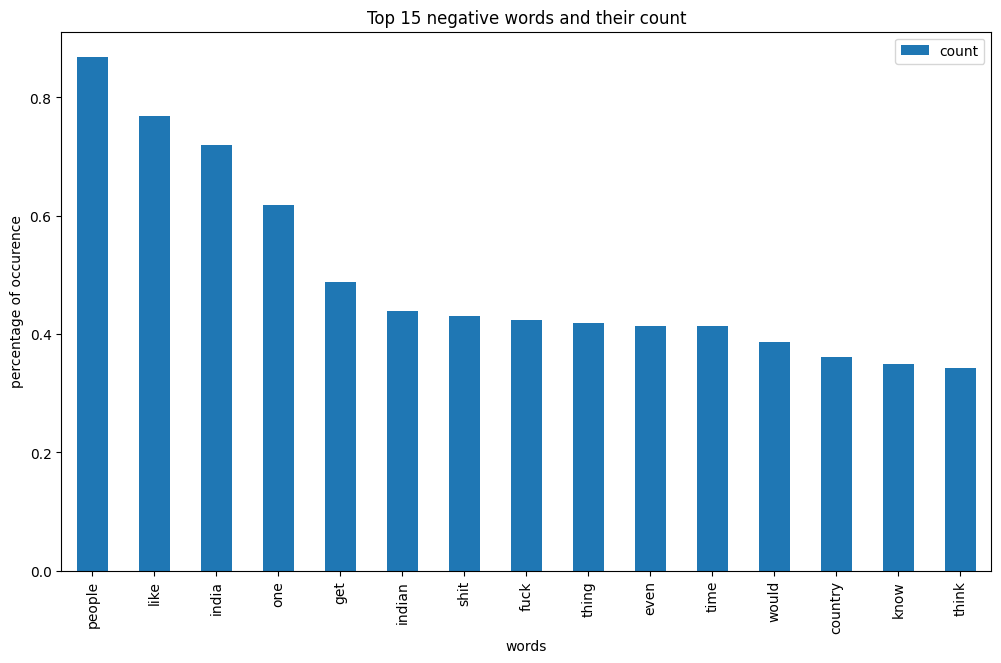

In [41]:
# bar plot for top 15 negative sentiment words
(
    pd.DataFrame(top_15_negative,columns=['word','count'])
    .set_index('word')
    .div(len(negative_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7)) 
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 negative words and their count")
plt.show()

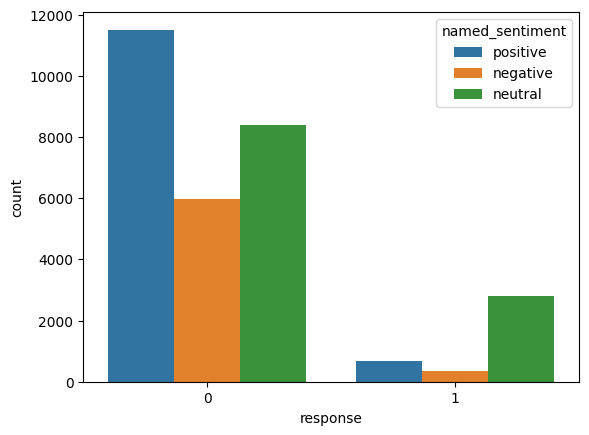

In [42]:
# distribution of responses among sentiments
sns.countplot(final_df,x='response',hue='named_sentiment');

**Response** --> This column denotes those comments which are a length of 3 or less words, which cannot be considered a comment but are feedbacks or responses

In [43]:
# response comments

(
    final_df
    .loc[(final_df['response'] == 1),"comment"]
)

18              zarus
46         nam indeed
47          jbdbxpxga
71       law headline
92          dry state
             ...     
37230        nice try
37235                
37239             pmd
37244           jesus
37247       haha nice
Name: comment, Length: 3849, dtype: object

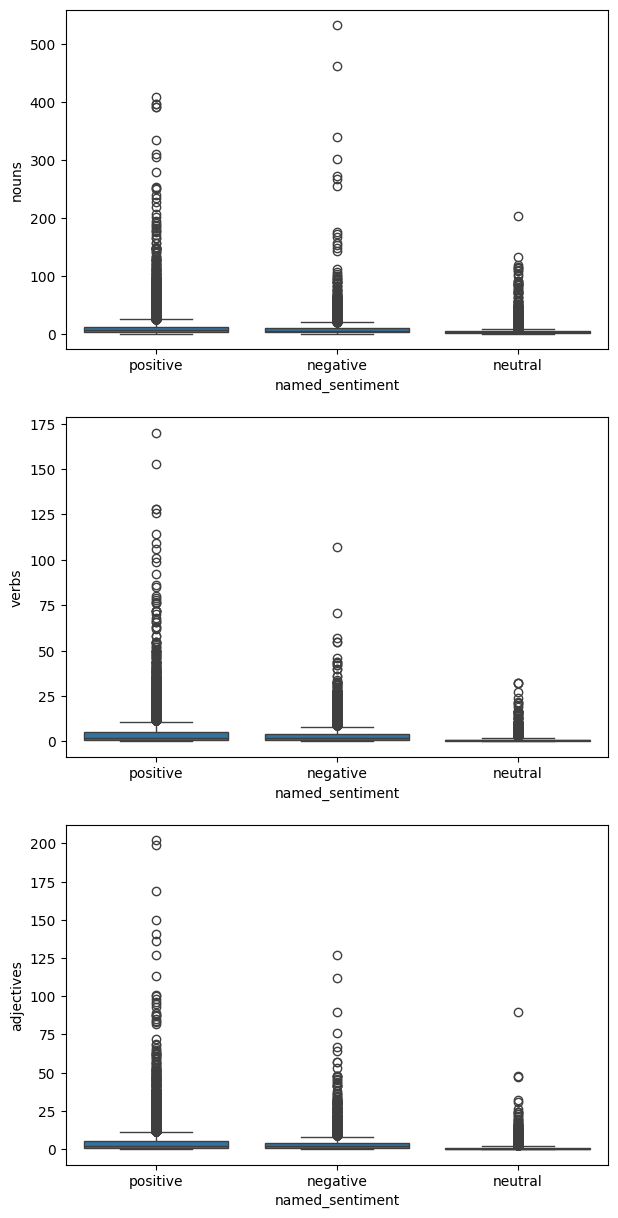

In [44]:
# boxplots for pos tags for each sentiment

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(7,15))

for ind,y in enumerate(final_df.columns[-3:].to_list()):
    sns.boxplot(data=final_df,x='named_sentiment',y=y,ax=ax[ind])

In [52]:
from math import floor

In [53]:
# statistical summary

sentiment_grp[['nouns','adjectives','verbs']].agg(["median","mean"]).map(floor)

nouns      adjectives       verbs     
                median mean     median mean median mean
named_sentiment                                        
negative             5    9          2    3      2    3
neutral              3    4          0    0      1    0
positive             6   10          2    4      2    4